# Importing the Data :

In [2]:
import pandas as pd

customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions.csv')

# Preview data
customers.head()


,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [3]:
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


# Data Preprocessing :

In [5]:
# Merge customers with transaction data based on CustomerID
merged_data = pd.merge(customers, transactions, on='CustomerID')

# Preview merged data
merged_data.head()

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,455.72
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64


# Feature Engineering :

In [6]:
# Group the merged data by CustomerID to create features
customer_features = merged_data.groupby('CustomerID').agg({
    'TransactionID': 'count',  # Total number of transactions
    'TotalValue': 'sum',       # Total spending
    'Quantity': 'sum'          # Total quantity purchased
}).reset_index()

# Rename the columns for better understanding
customer_features.columns = ['CustomerID', 'TotalTransactions', 'TotalSpend', 'TotalQuantity']

# Preview the customer features
customer_features.head()


,CustomerID,TotalTransactions,TotalSpend,TotalQuantity
0,C0001,5,3354.52,12
1,C0002,4,1862.74,10
2,C0003,4,2725.38,14
3,C0004,8,5354.88,23
4,C0005,3,2034.24,7


# Normalization :

In [7]:
from sklearn.preprocessing import StandardScaler

# Normalize the customer features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['TotalTransactions', 'TotalSpend', 'TotalQuantity']])


# K-Means Clustring :

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Try clustering for different values of k (2 to 10)
db_scores = []
k_values = list(range(2, 11))

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)

    # Calculate DB index for the current clustering
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    db_scores.append(db_index)

# Print the DB index for each value of k
for i, k in enumerate(k_values):
    print(f"K: {k}, DB Index: {db_scores[i]}")

K: 2, DB Index: 0.7233652695141874
K: 3, DB Index: 0.7726853895682169
K: 4, DB Index: 0.8650620583623065
K: 5, DB Index: 0.8967286185530714
K: 6, DB Index: 0.9321032761106421
K: 7, DB Index: 0.9284617501865761
K: 8, DB Index: 0.9217426294642852
K: 9, DB Index: 1.0765143619197992
K: 10, DB Index: 1.0320081943154773


# Choosing Optimal Cuters :

In [9]:
# Choose the optimal number of clusters (where DB index is lowest)
optimal_k = k_values[db_scores.index(min(db_scores))]
print(f"Optimal number of clusters based on DB Index: {optimal_k}")

# Re-run K-Means with the optimal number of clusters
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = final_kmeans.fit_predict(scaled_features)

Optimal number of clusters based on DB Index: 2


# Evaluation :

In [10]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score for the final clustering
sil_score = silhouette_score(scaled_features, customer_features['Cluster'])
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.49487297008885417


# Visualizing the Clusters :

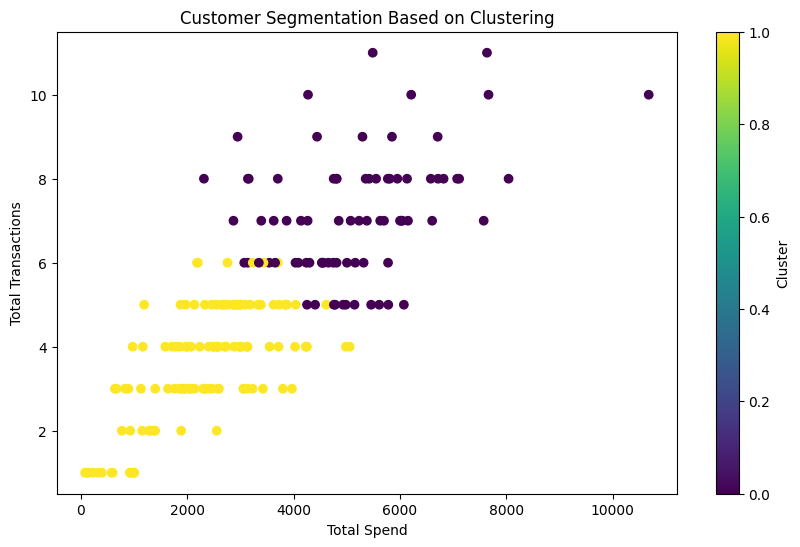

In [11]:
import matplotlib.pyplot as plt

# Plotting clusters based on TotalSpend and TotalTransactions
plt.figure(figsize=(10, 6))
plt.scatter(customer_features['TotalSpend'], customer_features['TotalTransactions'], c=customer_features['Cluster'], cmap='viridis')
plt.xlabel('Total Spend')
plt.ylabel('Total Transactions')
plt.title('Customer Segmentation Based on Clustering')
plt.colorbar(label='Cluster')
plt.show()